In [2]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Layer, Input, Conv2D, Dense, Flatten, Reshape, Lambda
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_datasets as tfds
import cv2
import numpy as np
import matplotlib.pyplot as plt
import datetime, os
import warnings
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)

Tensorflow 2.15.0


In [3]:
strategy = tf.distribute.MirroredStrategy()
num_devices = strategy.num_replicas_in_sync
print('Number of devices: {}'.format(num_devices))

Number of devices: 1


### Preparing the data

In [4]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2024-05-18 22:15:49--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.216.8, 52.219.120.160, 52.219.120.208, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.216.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  58.3MB/s    in 25s     

2024-05-18 22:16:15 (55.8 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [5]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

os.listdir("data_faces")

['img_align_celeba']

In [6]:
# Set the path to the directory containing the extracted images
image_dir = os.path.join('data_faces', 'img_align_celeba')

# Function to preprocess the images
def preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [218, 178])  # Resize to the original CelebA size
    return img

# Create a dataset from the image files
file_pattern = os.path.join(image_dir, '*.jpg')
dataset = tf.data.Dataset.list_files(file_pattern, shuffle=True)
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Split into train and test datasets
total_count = tf.data.experimental.cardinality(dataset).numpy()
train_count = int(0.9 * total_count)
test_count = total_count - train_count

ds_train = dataset.take(train_count)
ds_test_ = dataset.skip(train_count)

# Verify dataset
for image in ds_train.take(1):
    print(image.shape)

(218, 178, 3)


In [7]:
batch_size = 32 * num_devices  # Adjust batch size according to the number of devices

# Preprocess function
def preprocess(sample):
    image = tf.image.resize(sample, [112, 112])
    image = tf.cast(image, tf.float32) / 255.  # Normalize pixel values to [0, 1]
    return image, image

# Preprocess and batch the training dataset
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.shuffle(128)
ds_train = ds_train.batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

# Preprocess and batch the test dataset
ds_test = ds_test_.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
# Mock ds_info similar to tfds.load
ds_info = {
    'name': 'celeb_a',
    'splits': {
        'train': {'num_examples': train_count},
        'test': {'num_examples': test_count}
    }
}

train_num = ds_info['splits']['train']['num_examples']
test_num = ds_info['splits']['test']['num_examples']

print(f"Training samples: {train_num}, Test samples: {test_num}")

Training samples: 182339, Test samples: 20260


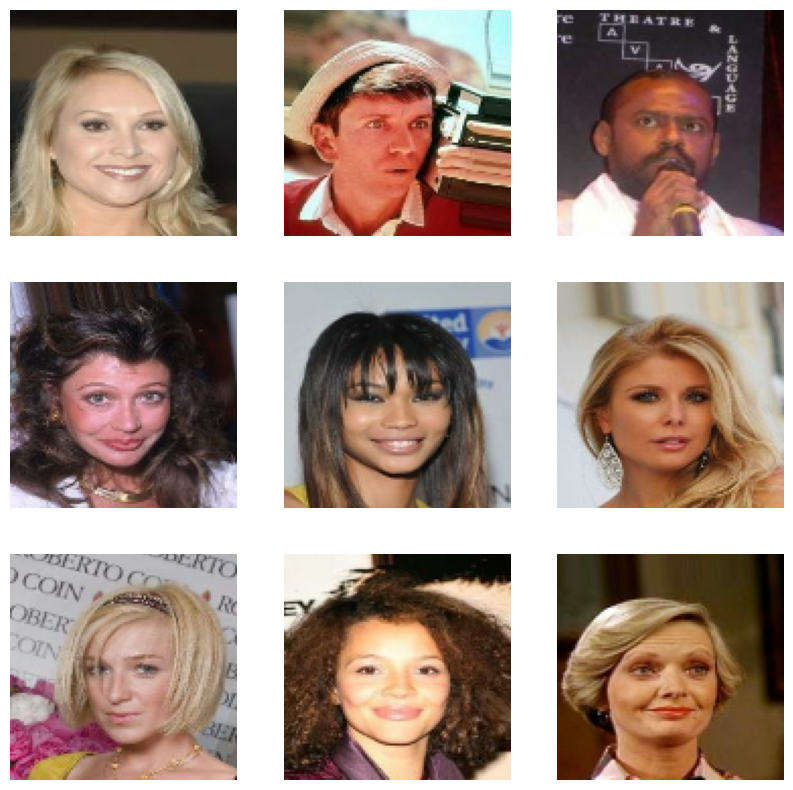

In [9]:
def show_examples(dataset, num_examples=9):
    plt.figure(figsize=(10, 10))
    count = 0
    for images, _ in dataset:
        for i in range(images.shape[0]):
            if count == num_examples:
                break
            ax = plt.subplot(3, 3, count + 1)
            plt.imshow(images[i].numpy())
            plt.axis("off")
            count += 1
        if count == num_examples:
            break

# Show examples from the training dataset
show_examples(ds_train)

### Defining the VAE Model

In [10]:
class GaussianSampling(Layer):
    def call(self, inputs):
        means, logvar = inputs
        epsilon = tf.random.normal(shape=tf.shape(means), mean=0., stddev=1.)
        samples = means + tf.exp(0.5 * logvar) * epsilon
        return samples

In [11]:
class DownConvBlock(Layer):
    count = 0
    def __init__(self, filters, kernel_size=(3,3), strides=1, padding='same'):
        super(DownConvBlock, self).__init__(name=f"DownConvBlock_{DownConvBlock.count}")
        DownConvBlock.count += 1
        self.forward = Sequential([
            Conv2D(filters, kernel_size, strides, padding),
            BatchNormalization(),
            LeakyReLU(0.2)
        ])
    def call(self, inputs):
        return self.forward(inputs)

In [12]:
class UpConvBlock(Layer):
    count = 0
    def __init__(self, filters, kernel_size=(3,3), padding='same'):
        super(UpConvBlock, self).__init__(name=f"UpConvBlock_{UpConvBlock.count}")
        UpConvBlock.count += 1
        self.forward = Sequential([
            Conv2D(filters, kernel_size, 1, padding),
            LeakyReLU(0.2),
            UpSampling2D((2,2))
        ])
    def call(self, inputs):
        return self.forward(inputs)

In [13]:
class Encoder(Layer):
    def __init__(self, z_dim, name='encoder'):
        super(Encoder, self).__init__(name=name)
        self.features_extract = Sequential([
            DownConvBlock(filters=32, kernel_size=(3,3), strides=2),
            DownConvBlock(filters=32, kernel_size=(3,3), strides=2),
            DownConvBlock(filters=64, kernel_size=(3,3), strides=2),
            DownConvBlock(filters=64, kernel_size=(3,3), strides=2),
            Flatten()
        ])
        self.dense_mean = Dense(z_dim, name='mean')
        self.dense_logvar = Dense(z_dim, name='logvar')
        self.sampler = GaussianSampling()
    def call(self, inputs):
        x = self.features_extract(inputs)
        mean = self.dense_mean(x)
        logvar = self.dense_logvar(x)
        z = self.sampler([mean, logvar])
        return z, mean, logvar

In [14]:
class Decoder(Layer):
    def __init__(self, z_dim, name='decoder'):
        super(Decoder, self).__init__(name=name)
        self.forward = Sequential([
            Dense(7*7*64, activation='relu'),
            Reshape((7,7,64)),
            UpConvBlock(filters=64, kernel_size=(3,3)),
            UpConvBlock(filters=64, kernel_size=(3,3)),
            UpConvBlock(filters=32, kernel_size=(3,3)),
            UpConvBlock(filters=32, kernel_size=(3,3)),
            Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid')
        ])
    def call(self, inputs):
        return self.forward(inputs)

In [15]:
class VAE(Model):
    def __init__(self, z_dim, name='VAE'):
        super(VAE, self).__init__(name=name)
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        self.mean = None
        self.logvar = None
    def call(self, inputs):
        z, self.mean, self.logvar = self.encoder(inputs)
        out = self.decoder(z)
        return out

### Training the VAE

In [16]:
# Use strategy scope for multi-GPU training
if num_devices > 1:
    with strategy.scope():
        vae = VAE(z_dim=200)
else:
    vae = VAE(z_dim=200)

In [17]:
# Define loss functions
def vae_kl_loss(y_true, y_pred):
    kl_loss = -0.5 * tf.reduce_mean(1 + vae.logvar - tf.square(vae.mean) - tf.exp(vae.logvar))
    return kl_loss

def vae_rc_loss(y_true, y_pred):
    rc_loss = tf.keras.losses.MSE(y_true, y_pred)
    return rc_loss

def vae_loss(y_true, y_pred):
    kl_loss = vae_kl_loss(y_true, y_pred)
    rc_loss = vae_rc_loss(y_true, y_pred)
    kl_weight_const = 0.01
    return kl_weight_const * kl_loss + rc_loss

In [18]:
# Checkpoints and early stopping
model_path = "vae_faces_cele_a.h5"
checkpoint = ModelCheckpoint(
    model_path,
    monitor='vae_rc_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=True
)
early = EarlyStopping(
    monitor='vae_rc_loss',
    mode='auto',
    patience=3
)
callbacks_list = [checkpoint, early]

# Learning rate schedule
initial_learning_rate = 1e-3
steps_per_epoch = int(np.round(train_num/batch_size))
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=0.96,
    staircase=True
)

In [ ]:
vae.compile(
    loss=[vae_loss],
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=3e-3),
    metrics=[vae_kl_loss, vae_rc_loss]
)
history = vae.fit(ds_train, validation_data=ds_test, epochs=50, callbacks=callbacks_list)

Epoch 1/50
5696/5698 [============================>.] - ETA: 0s - loss: 0.0257 - vae_kl_loss: 0.4468 - vae_rc_loss: 0.0212
Epoch 1: vae_rc_loss improved from inf to 0.02119, saving model to vae_faces_cele_a.h5
5698/5698 [==============================] - 80s 13ms/step - loss: 0.0257 - vae_kl_loss: 0.4468 - vae_rc_loss: 0.0212 - val_loss: 0.0194 - val_vae_kl_loss: 0.4354 - val_vae_rc_loss: 0.0151
Epoch 2/50
5693/5698 [============================>.] - ETA: 0s - loss: 0.0193 - vae_kl_loss: 0.4282 - vae_rc_loss: 0.0150
Epoch 2: vae_rc_loss improved from 0.02119 to 0.01502, saving model to vae_faces_cele_a.h5
5698/5698 [==============================] - 71s 12ms/step - loss: 0.0193 - vae_kl_loss: 0.4282 - vae_rc_loss: 0.0150 - val_loss: 0.0202 - val_vae_kl_loss: 0.4462 - val_vae_rc_loss: 0.0157
Epoch 3/50
5698/5698 [==============================] - ETA: 0s - loss: 0.0181 - vae_kl_loss: 0.4265 - vae_rc_loss: 0.0138
Epoch 3: vae_rc_loss improved from 0.01502 to 0.01383, saving model to vae_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the model to Google Drive
vae.save('/content/drive/MyDrive/vae_model', save_format='tf')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Model Evaluation and Visualization

In [19]:
from tensorflow.keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')

vae_ = load_model('/content/drive/MyDrive/vae_model',
                  custom_objects={'vae_loss': vae_loss, 'vae_kl_loss': vae_kl_loss, 'vae_rc_loss': vae_rc_loss})

Mounted at /content/drive


1/1 [==============================] - 0s 257ms/step


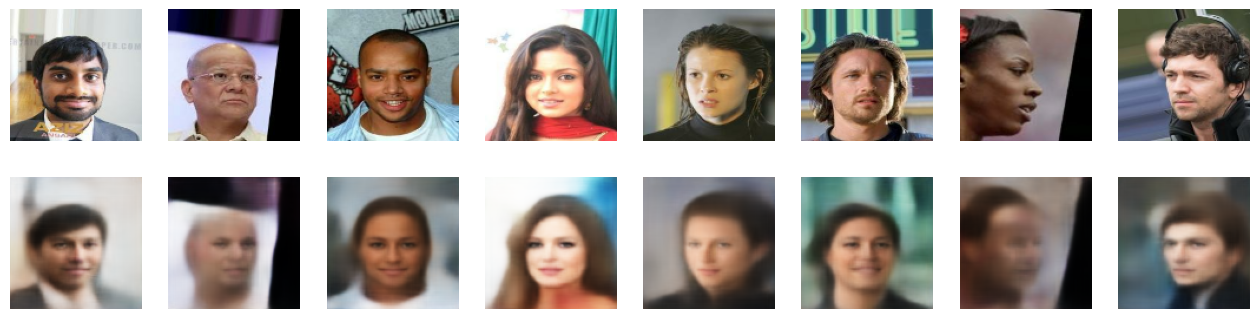

In [20]:
# Load a batch of images from the training set
images, labels = next(iter(ds_train))

# Load the best model weights: vae_.load_weights(model_path)

# Predict outputs using the trained VAE
outputs = vae_.predict(images)

# Display original and reconstructed images
grid_col = 8
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*2, grid_row*2))
i = 0
for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row, col].imshow(images[i])
        axarr[row, col].axis('off')
        axarr[row+1, col].imshow(outputs[i])
        axarr[row+1, col].axis('off')
        i += 1
# f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)
plt.show()

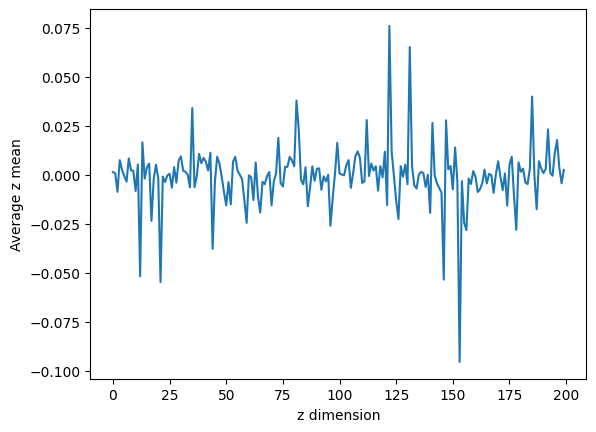

In [21]:
avg_z_mean = []
avg_z_std = []
for i in range(steps_per_epoch):
    images, labels = next(iter(ds_train))
    z, z_mean, z_logvar = vae_.encoder(images)
    avg_z_mean.append(np.mean(z_mean, axis=0))
    avg_z_std.append(np.mean(np.exp(0.5 * z_logvar), axis=0))

avg_z_mean = np.mean(avg_z_mean, axis=0)
avg_z_std = np.mean(avg_z_std, axis=0)

plt.plot(avg_z_mean)
plt.ylabel("Average z mean")
plt.xlabel("z dimension")
plt.show()

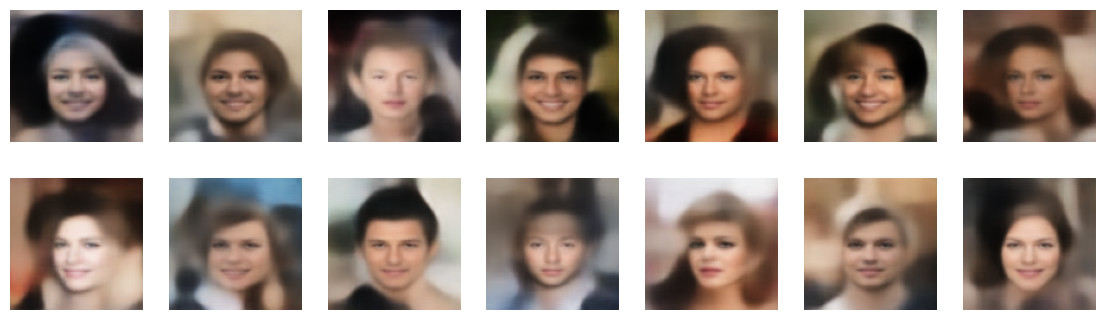

In [21]:
# Generate new images by sampling from the latent space
z_dim = 200
z_samples = np.random.normal(loc=0, scale=1, size=(25, z_dim))
images = vae_.decoder(z_samples.astype(np.float32))

grid_col = 7
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(2*grid_col, 2*grid_row))
i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row, col].imshow(images[i])
        axarr[row, col].axis('off')
        i += 1
# f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)
plt.show()

### Attributes and Additional Exploration

In [22]:
import pandas as pd

# Path to the attributes file
attributes_file_path = os.path.join('/content/drive/MyDrive', 'list_attr_celeba.txt')

# Load the attributes file
attributes_df = pd.read_csv(attributes_file_path, delim_whitespace=True, skiprows=1)

# Convert attributes to binary (0 or 1) instead of -1 or 1
attributes_df = (attributes_df + 1) // 2

# Display the first few rows to understand the structure
attributes_df.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [88]:
# List of attribute names
attributes = [
    '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
    'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
    'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
    'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
    'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
    'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks',
    'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
    'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie',
    'Young'
]
# Function to convert attributes array to dictionary
def convert_attributes_to_dict(attribute_values):
    return {attributes[i]: attribute_values[i] for i in range(len(attributes))}

# Function to load and preprocess images
def load_and_preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

# Path to the directory containing the extracted images
image_dir = 'data_faces/img_align_celeba'
# Create a dataset from the image files and attributes
image_files = [os.path.join(image_dir, img) for img in attributes_df.index]
labels = attributes_df.values.astype('bool')

# Combine the image paths and attributes into a dictionary
def create_sample_dict(image_file, label):
    image = load_and_preprocess_image(image_file)
    attribute_dict = convert_attributes_to_dict(label)
    return {'image': image, 'attributes': attribute_dict}

# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((image_files, labels))
dataset = dataset.map(lambda x, y: create_sample_dict(x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [24]:
# Split into train and test datasets
total_count = len(image_files)
train_count = int(0.9 * total_count)
test_count = total_count - train_count

ds_train = dataset.take(train_count)
ds_test = dataset.skip(train_count)

# Verify dataset structure
for sample in ds_train.take(1):
    print(sample['image'].shape, sample['attributes']['5_o_Clock_Shadow'])

(218, 178, 3) tf.Tensor(False, shape=(), dtype=bool)


In [ ]:
def preprocess_attrib(sample, attribute):
    image = sample['image']
    image = tf.image.resize(image, [112, 112])
    image = tf.cast(image, tf.float32) / 255.
    return image, sample['attributes'][attribute]

def extract_attrib_vector(attribute, ds):
    batch_size = 32 * num_devices
    ds = ds.map(lambda x: preprocess_attrib(x, attribute))
    ds = ds.batch(batch_size)

    steps_per_epoch = int(np.round(test_count / batch_size))

    pos_z = []
    pos_z_num = []
    neg_z = []
    neg_z_num = []
    for i in range(steps_per_epoch):
        print("{} / {}".format(i+1, steps_per_epoch))
        images, labels = next(iter(ds))
        z, z_mean, z_logvar = vae_.encoder(images)
        z = z.numpy()

        step_pos_z = z[labels==True]
        pos_z.append(np.mean(step_pos_z, axis=0))
        pos_z_num.append(step_pos_z.shape[0])

        step_neg_z = z[labels==False]
        neg_z.append(np.mean(step_neg_z, axis=0))
        neg_z_num.append(step_neg_z.shape[0])

    avg_pos_z = np.average(pos_z, axis=0, weights=pos_z_num)
    avg_neg_z = np.average(neg_z, axis=0, weights=neg_z_num)
    attrib_vector = avg_pos_z - avg_neg_z
    return attrib_vector


attribs_vectors1 = {}
for attrib in ['Male','Eyeglasses']:
    print(attrib)
    attribs_vectors1[attrib] = extract_attrib_vector(attrib, ds_test)

In [28]:
import pickle

# Serialize and save to a file
with open("attribs_vectors1.pkl", "wb") as f:
    pickle.dump(attribs_vectors1, f)

from google.colab import files

# Download the file
files.download("attribs_vectors1.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
attribs_vectors2 = {}
for attrib in ['Young','Smiling','Blond_Hair','Pale_Skin','Mustache','Attractive']:
    print(attrib)
    attribs_vectors2[attrib] = extract_attrib_vector(attrib, ds_test)

In [58]:
with open("attribs_vectors2.pkl", "wb") as f:
    pickle.dump(attribs_vectors2, f)

# Download the file
files.download("attribs_vectors2.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Latent Space Exploration

In [ ]:
# Step 1: Upload the file
uploaded = files.upload()

# Step 2: Load the dictionary from the uploaded file
filename = list(uploaded.keys())[0]

with open(filename, "rb") as f:
    attribs_vectors1 = pickle.load(f)

In [59]:
uploaded = files.upload()

filename = list(uploaded.keys())[0]
with open(filename, "rb") as f:
    attribs_vectors2 = pickle.load(f)

Saving attribs_vectors3.pkl to attribs_vectors3 (1).pkl


In [60]:
attribs_vectors = {**attribs_vectors1, **attribs_vectors2}

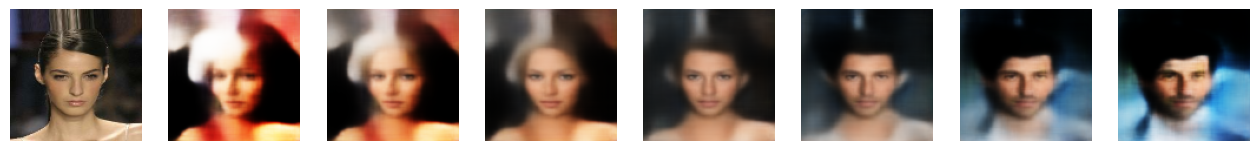

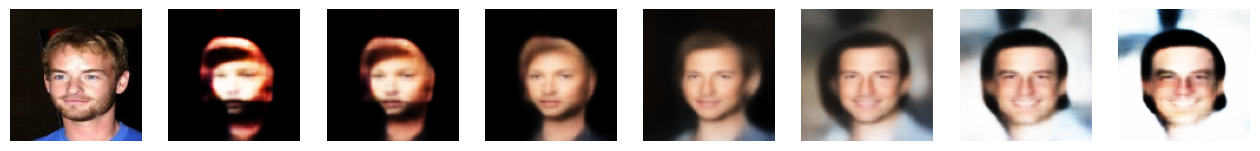

In [81]:
def explore_latent_variable(image, attrib):
    grid_col = 8
    grid_row = 1

    z_samples, _, _ = vae_.encoder(tf.expand_dims(image, 0))
    f, axarr = plt.subplots(grid_row, grid_col, figsize=(2*grid_col, 2*grid_row))

    i = 0
    row = 0
    step = -3

    axarr[0].imshow(image)
    axarr[0].axis('off')
    for col in range(1, grid_col):
        new_z_samples = z_samples + step * attribs_vectors[attrib]
        reconstructed_image = vae_.decoder(new_z_samples)
        axarr[col].imshow(reconstructed_image[0])
        axarr[col].axis('off')
        step += 1
    # f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)
    plt.show()


# Use the function to explore various attributes
ds_test1 = ds_test_.map(preprocess).batch(100)
images, labels = next(iter(ds_test1))

explore_latent_variable(images[34], 'Male')
explore_latent_variable(images[20], 'Eyeglasses')

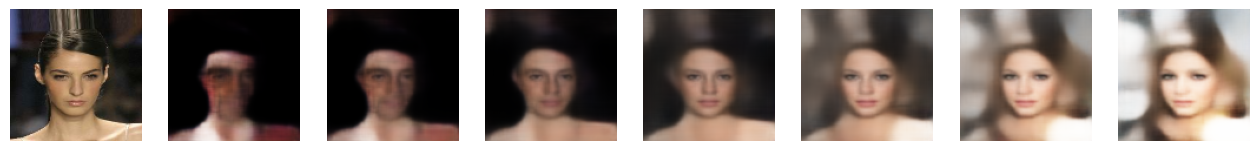

In [82]:
explore_latent_variable(images[34], 'Attractive')

In [66]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def explore_latent_variable(Male=(-3,3,0.1),
                            Eyeglasses=(-3,4,0.1),
                            Young=(-3,3,0.1),
                            Smiling=(-3,3,0.1),
                            Blond_Hair=(-3,3,0.1),
                            Pale_Skin=(-3,3,0.1),
                            Attractive=(-3,3,0.1)):
    new_z_samples = z_samples + \
                    Male*attribs_vectors['Male'] + \
                    Eyeglasses*attribs_vectors['Eyeglasses'] + \
                    Young*attribs_vectors['Young'] + \
                    Smiling*attribs_vectors['Smiling'] + \
                    Blond_Hair*attribs_vectors['Blond_Hair'] + \
                    Pale_Skin*attribs_vectors['Pale_Skin'] + \
                    Attractive*attribs_vectors['Attractive']
    images = vae_.decoder(new_z_samples)
    plt.figure(figsize=(4,4))
    plt.axis('off')
    plt.imshow(images[0])
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='Male', max=3.0, min=-3.0), FloatSlider(value=0.0, de…

### Latent Space Visualization

In [104]:
def convert_dict_to_attributes(attribute_dict):
    return [attribute_dict[attr] for attr in attributes]

def preprocess_(sample):
    image = sample['image']
    image = tf.image.resize(image, [112, 112])
    image = tf.cast(image, tf.float32) / 255.
    return image, convert_dict_to_attributes(sample['attributes'])

ds_test2 = ds_test.map(lambda x: preprocess_(x)).batch(100)

In [105]:
latent_means, labels = [], []
for images, lbls in ds_test2:
    _, z_mean, _ = vae_.encoder(images)
    latent_means.append(z_mean.numpy())
    labels.append(lbls.numpy())

latent_means = np.concatenate(latent_means, axis=0)
labels = np.concatenate(labels, axis=0)

# Randomly select 100 indices
sample_indices = np.random.choice(latent_means.shape[0], size=100, replace=False)

# Sample 100 data points
sampled_latent_means = latent_means[sample_indices]
sampled_labels = labels[sample_indices]

In [106]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the latent space to 3D
tsne = TSNE(n_components=3, random_state=42)
latent_means_3d = tsne.fit_transform(sampled_latent_means)

In [110]:
import plotly.express as px

# Choose the attribute you want to visualize
attr_index =  attributes.index('Male')
attribute_labels = sampled_labels[:, attr_index]

# Create a DataFrame for better handling of the data
df = pd.DataFrame(latent_means_3d, columns=['Component 1', 'Component 2', 'Component 3'])
df['Attribute'] = attribute_labels

# Create the 3D scatter plot
fig = px.scatter_3d(df, x='Component 1', y='Component 2', z='Component 3', color='Attribute', opacity=0.7)

# Update the layout for better visualization
fig.update_layout(
    title="3D t-SNE Projection of the Latent Space Colored by Attribute",
    scene=dict(
        xaxis_title='t-SNE Component 1',
        yaxis_title='t-SNE Component 2',
        zaxis_title='t-SNE Component 3'
    ),
    width=800,
    height=700
)

# Show the plot
fig.show()

### Exploring Attribute Contribution to Atractiveness

In [85]:
# Analyze contributions to "Attractive"
attractive_vector = attribs_vectors['Attractive']

contributions = {}
for attribute, vector in attribs_vectors.items():
    if attribute != 'Attractive':
        contribution = np.dot(attractive_vector, vector)
        contributions[attribute] = contribution

# Sort contributions
sorted_contributions = sorted(contributions.items(), key=lambda item: item[1], reverse=True)

# Print sorted contributions
for attribute, contribution in sorted_contributions:
    print(f"Attribute: {attribute}, Contribution: {contribution}")

Attribute: Young, Contribution: 10.555622349810811
Attribute: Blond_Hair, Contribution: 2.4787840135279646
Attribute: Pale_Skin, Contribution: 1.858159854543899
Attribute: Mustache, Contribution: 0.4888948008471879
Attribute: Smiling, Contribution: -1.4084687132421547
Attribute: Male, Contribution: -3.7646573029609263
Attribute: Eyeglasses, Contribution: -6.976633471299882
